# MoviesLens With Deep and Wide Neural Network
* This example walks through how to use the deep and wide algorithm to train against the movies lens dataset for recommendations
* Using a supervised model like deep and wide neural network we can incorporate many other pieces of feedback that would otherwise not be able to be in corporated in a matrix factorization model
* https://arxiv.org/abs/1606.07792
* Note that this implementation hashes all input features. This means that items like genre which have one to many items will have as many columns as there are unique combinations of features. As a result I will also create length width columns for tags and genres
* We will also assume that ratings 4+ mean that a user will watch a recommended movie
* The container does train/validation/test splits automatically, so we only need to prepare the final dataset

# Set up Environment

In [190]:
import pandas as pd
import numpy as np
# S3 prefix
prefix = 'movieslens-dnn'

# Define IAM role
import boto3
import re

import os
from sagemaker import get_execution_role

role = get_execution_role()

* Download the small version of the movie lens dataset here https://grouplens.org/datasets/movielens/100k/
* Unzip the files

In [5]:
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
movies_df = pd.read_csv('ml-latest-small/movies.csv')
tags_df = pd.read_csv('ml-latest-small/tags.csv')
links_df = pd.read_csv('ml-latest-small/links.csv')

In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [249]:
ratings_df[ratings_df['rating']>=4].shape[0]/ratings_df.shape[0]

0.4817723828791305

In [6]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


* Genres could be useful for recommendations, let's preprocess this data

# Code to Explode Tags & Genres Into Fixed Width Columns

In [201]:
def explode_item(x, sep, bins):
    slots = ['none']*bins
    seperated = x.split(sep)
    for i, entry in enumerate(seperated[:bins]):
        slots[i] = entry
    return slots

def create_exploded_features(df, column, sep, bins):
    exploded_items = [explode_item(x, sep, bins) for x in df[column].tolist()]
    column_headers = ['{}_{}'.format(column, i) for i in range(bins)]
    exploded_feat = pd.DataFrame(exploded_items,columns=column_headers)
    return pd.concat([df, exploded_feat],axis=1)

In [7]:
genre_lists = movies_df['genres'].str.split('|').tolist()
genre_set = set([item for items in genre_lists for item in items])

In [8]:
pd.Series(dict(zip(genre_set, [0]*len(genre_set))))

(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
IMAX                  0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
dtype: int64

In [9]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


* Tags could also be useful for recommendations, even if they are more sparse

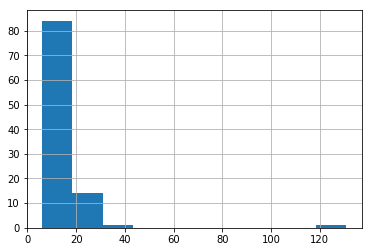

In [10]:
%matplotlib inline
tags_df['tag'].value_counts().head(100).hist()

In [11]:
tags_df['tag'].unique().size

1589

# Code to Procress Tags into DNN useable format

In [203]:
from copy import deepcopy

def fit_vocab(tags, cut_off):
    vocab = tags['tag'].str.lower().value_counts(normalize=True)>cut_off
    vocab_dict = (vocab[vocab==1]-1).to_dict()
    print('INFO - Finding Tag Vocabulary')
    print("{} words in the tags vocabulary".format(len(vocab_dict)))
    return vocab_dict

def explode_tags(tags, cut_off):
    vocab_dict = fit_vocab(tags, cut_off)
    vocab_series = [0]*tags.shape[0]
    print('INFO - Joining Tag Data to Ratings')
    for ix, user_movie in tags.iterrows():
        if ix % 500 ==0:
            print("Completed Expanded Tags in {} of {} rows".format(ix, tags.shape[0]))
        vocab_i = deepcopy(vocab_dict)
        tag = user_movie['tag'].lower()
        if tag in vocab_i:
            vocab_i[tag] = 1
        vocab_series[ix] = vocab_i
    tags_df = pd.DataFrame(vocab_series)
    return tags_df

def create_tags_categorical(tags, cut_off):
    exploded_tags = explode_tags(tags, cut_off)
    exploded_tags.columns = ["tag_{}".format(c) for c in exploded_tags.columns]
    merged_df = pd.concat((tags, exploded_tags),axis=1).groupby(['userId','movieId']).sum().reset_index()
    tag_strs = ['none']*merged_df.shape[0]
    for ix, row in merged_df.iterrows():
        tags = row.index[[x.startswith('tag') for x in row.index]]
        tags_present = row[tags]>0
        if tags_present.shape[0] > 0:
            tags = tags_present.index.tolist()
            tag_str = '_'.join([x for x in tags])
            tag_strs[ix] = tag_str
    merged_df = merged_df.drop(exploded_tags,axis=1)
    merged_df['tags'] = tag_strs
    return merged_df

# Final Data Processing Code 

* This links together the functions to process genres & tags
* We also add a binary indicator if a user has supplied tags for a given film as tags are infrequent

In [251]:
def label_convert(x,cutoff):
    if x >= cutoff:
        return 1
    else:
        return 0

def create_prepared_dataset(ratings, movies, tags, tag_cutoff):
    ratings_genre = pd.merge(ratings, movies, on=['movieId'])
    ratings_genre = ratings_genre.drop(['timestamp','title'],axis=1)
    tags_data = create_tags_categorical(tags_df, tag_cutoff)
    tags_data = tags_data.drop('timestamp',axis=1)
    print('INFO - Merging All Data')
    combined_data = pd.merge(ratings_genre,tags_data, on=['userId','movieId'],how='left').fillna(np.nan)
    combined_data = combined_data.rename({'rating':'label'},axis=1)
    combined_data['user_supplied_tags'] = ~combined_data['tags'].isnull()
    combined_data['user_supplied_tags'] = combined_data['user_supplied_tags'].map({False: 'no_tags_supplied', True: 'tags_supplied'})
    combined_data['tags'] = combined_data['tags'].fillna('none')
    combined_data = create_exploded_features(combined_data, 'tags', '_', 10)
    combined_data = create_exploded_features(combined_data, 'genres', '|', 5)
    combined_data['label'] = combined_data['label'].apply(lambda x: label_convert(x,4))
    return combined_data

In [252]:
data_set_prepped = create_prepared_dataset(ratings_df, movies_df, tags_df, 0.0005)

INFO - Finding Tag Vocabulary
550 words in the tags vocabulary
INFO - Joining Tag Data to Ratings
Completed Expanded Tags in 0 of 3683 rows
Completed Expanded Tags in 500 of 3683 rows
Completed Expanded Tags in 1000 of 3683 rows
Completed Expanded Tags in 1500 of 3683 rows
Completed Expanded Tags in 2000 of 3683 rows
Completed Expanded Tags in 2500 of 3683 rows
Completed Expanded Tags in 3000 of 3683 rows
Completed Expanded Tags in 3500 of 3683 rows
INFO - Merging All Data


In [253]:
data_set_prepped.head()

,userId,movieId,label,genres,tags,user_supplied_tags,tags_0,tags_1,tags_2,tags_3,...,tags_5,tags_6,tags_7,tags_8,tags_9,genres_0,genres_1,genres_2,genres_3,genres_4
0,1,1,1,Adventure|Animation|Children|Comedy|Fantasy,none,no_tags_supplied,none,none,none,none,...,none,none,none,none,none,Adventure,Animation,Children,Comedy,Fantasy
1,5,1,1,Adventure|Animation|Children|Comedy|Fantasy,none,no_tags_supplied,none,none,none,none,...,none,none,none,none,none,Adventure,Animation,Children,Comedy,Fantasy
2,7,1,1,Adventure|Animation|Children|Comedy|Fantasy,none,no_tags_supplied,none,none,none,none,...,none,none,none,none,none,Adventure,Animation,Children,Comedy,Fantasy
3,15,1,0,Adventure|Animation|Children|Comedy|Fantasy,none,no_tags_supplied,none,none,none,none,...,none,none,none,none,none,Adventure,Animation,Children,Comedy,Fantasy
4,17,1,1,Adventure|Animation|Children|Comedy|Fantasy,none,no_tags_supplied,none,none,none,none,...,none,none,none,none,none,Adventure,Animation,Children,Comedy,Fantasy


In [254]:
data_set_prepped.columns

Index(['userId', 'movieId', 'label', 'genres', 'tags', 'user_supplied_tags',
       'tags_0', 'tags_1', 'tags_2', 'tags_3', 'tags_4', 'tags_5', 'tags_6',
       'tags_7', 'tags_8', 'tags_9', 'genres_0', 'genres_1', 'genres_2',
       'genres_3', 'genres_4'],
      dtype='object')

In [255]:
data_set_prepped['user_supplied_tags'].value_counts()

no_tags_supplied    99201
tags_supplied        1635
Name: user_supplied_tags, dtype: int64

# Create A Sample For Local Tests

In [256]:
data_set_prepped.sample(2000).to_csv('keras_wide_deep/local_test/test_dir/input/data/training/sample_data.csv',index=None)

* Navigate to the field-aware-fm folder
* run ./build.sh with a name of a container to push to ecr
* After this finishes navigate to local_test and run ./train.sh with the same container name
* Verify that training completes properly

# Create the session

In [257]:
import sagemaker as sage
from time import gmtime, strftime

sess = sage.Session()

# Save data in csv format

In [258]:
try:
    os.mkdir('data')
except FileExistsError:
    pass

In [259]:
data_set_prepped.to_csv('data/movielens_expanded.csv',index=None)

# Upload the data for training

In [260]:
WORK_DIRECTORY = 'data'

data_location = sess.upload_data(WORK_DIRECTORY, key_prefix=prefix)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-178197730631


In [261]:
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/keras-wide-deep:latest'.format(account, region)

dnn = sage.estimator.Estimator(image,
                       role, 1, 'ml.c4.8xlarge',
                       output_path="s3://{}/output".format(sess.default_bucket()),
                       sagemaker_session=sess,train_volume_size=50)

# Set Model Hyperparameters

* The deep and wide network has wide columns and deep columns, additional cross product columns can aslo be added
* We will use all columns in the wide model, but limit those included in the deep model

In [262]:
len(data_set_prepped.columns)

21

In [263]:
data_set_prepped.head()

,userId,movieId,label,genres,tags,user_supplied_tags,tags_0,tags_1,tags_2,tags_3,...,tags_5,tags_6,tags_7,tags_8,tags_9,genres_0,genres_1,genres_2,genres_3,genres_4
0,1,1,1,Adventure|Animation|Children|Comedy|Fantasy,none,no_tags_supplied,none,none,none,none,...,none,none,none,none,none,Adventure,Animation,Children,Comedy,Fantasy
1,5,1,1,Adventure|Animation|Children|Comedy|Fantasy,none,no_tags_supplied,none,none,none,none,...,none,none,none,none,none,Adventure,Animation,Children,Comedy,Fantasy
2,7,1,1,Adventure|Animation|Children|Comedy|Fantasy,none,no_tags_supplied,none,none,none,none,...,none,none,none,none,none,Adventure,Animation,Children,Comedy,Fantasy
3,15,1,0,Adventure|Animation|Children|Comedy|Fantasy,none,no_tags_supplied,none,none,none,none,...,none,none,none,none,none,Adventure,Animation,Children,Comedy,Fantasy
4,17,1,1,Adventure|Animation|Children|Comedy|Fantasy,none,no_tags_supplied,none,none,none,none,...,none,none,none,none,none,Adventure,Animation,Children,Comedy,Fantasy


In [266]:
 dnn.hyperparam_dict = {
	"hash_columns": "True",
	"n_hash_columns": "1e6",
	"wide_columns": ['userId', 'movieId','genres', 'tags', 'user_supplied_tags',
       'tags_0', 'tags_1', 'tags_2', 'tags_3', 'tags_4', 'tags_5', 'tags_6',
       'tags_7', 'tags_8', 'tags_9', 'genres_0', 'genres_1', 'genres_2',
       'genres_3', 'genres_4'],
	"cross_columns": ['movieId','tags_0', 'tags_1', 'tags_2', 'tags_3', 'tags_4', 'tags_5', 'tags_6',
       'tags_7', 'tags_8', 'tags_9','user_supplied_tags'],
	"deep_columns": ['movieId','genres','userId'],
	"linear_regularization": "1e-4",
	"embeddings_regularizer": "1e-4",
	"nn_scale": "5",
	"lr": "0.001",
	"dropout": "0.35",
	"batch_size": "64",
	"epochs": "6",
	"optimizer": "Adam",
	"min_threshold": "25",
	"d1": "75",
	"task": "classification",
	"user_column": "userId",
	"d2": "25"
 }


* linear regularization & embedding regularization control the regularization penalty for the embedding layer and linear model
* learning rate controls the rate of updates from the gradient
* columns determine the number of unique columns
* optimizer controls the algorithm used for gradient descent
* min_threshold is the number of items per user needed to included in training
* user_column is passed to determine the number of items
* task is either regression or classification
* nn_scale controls the size of the latent factors 
* dropout controls the number of randomly chose neurons to freeze during training
* batch_size is size of the items passed to training at a time
* d1 and d2 are the sizes of the neural networks first and second layer


In [267]:
 dnn.fit(data_location)

INFO:sagemaker:Creating training-job with name: keras-wide-deep-2019-01-23-20-45-49-057


2019-01-23 20:45:49 Starting - Starting the training job...
2019-01-23 20:45:50 Starting - Launching requested ML instances......
2019-01-23 20:46:56 Starting - Preparing the instances for training......
2019-01-23 20:48:06 Downloading - Downloading input data
2019-01-23 20:48:06 Training - Downloading the training image...
2019-01-23 20:48:35 Training - Training image download completed. Training in progress.
Using TensorFlow backend.
Starting the training.
/opt/ml/input/data/training
['/opt/ml/input/data/training/movielens_expanded.csv']
(100836, 21)
Columns used for Linear Model
['userId', 'movieId', 'genres', 'tags', 'user_supplied_tags', 'tags_0', 'tags_1', 'tags_2', 'tags_3', 'tags_4', 'tags_5', 'tags_6', 'tags_7', 'tags_8', 'tags_9', 'genres_0', 'genres_1', 'genres_2', 'genres_3', 'genres_4']
Cross Product Columns
['movieId', 'tags_0', 'tags_1', 'tags_2', 'tags_3', 'tags_4', 'tags_5', 'tags_6', 'tags_7', 'tags_8', 'tags_9', 'user_supplied_tags']
Columns used for DNN
['movieId', 